<a href="https://colab.research.google.com/github/ranjith88697/Bootcamp_Acc/blob/main/Day7_RNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and Preprocessing Data

In [4]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
from keras.callbacks import EarlyStopping


In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")

print("Path to dataset files:", path)

100%|██████████| 23.4k/23.4k [00:00<00:00, 16.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rahulsah06/gooogle-stock-price/versions/1


In [16]:
# Importing the training set
dataset_train = pd.read_csv(path+"/Google_Stock_Price_Train.csv")

In [17]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [18]:
"Extracting only the Open price. Converting to a NumPy array. Shape becomes (number_of_days, 1)"
#train = dataset_train.loc[:, ["Open"]].values
features = dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']].values

features

array([[325.25, 332.83, 324.97, '663.59', '7,380,500'],
       [331.27, 333.87, 329.08, '666.45', '5,749,400'],
       [329.83, 330.75, 326.89, '657.21', '6,590,300'],
       ...,
       [793.7, 794.23, 783.2, '785.05', '1,153,800'],
       [783.33, 785.93, 778.92, '782.79', '744,300'],
       [782.75, 782.78, 770.41, '771.82', '1,770,000']], dtype=object)

In [20]:
# Feature Scaling
"RNNs work better when inputs are in a small numerical range. Stock prices vary widely → scaling stabilizes training. Scales values to [0, 1]. "
"fit_transform learns min/max from training data and scales it"

# Ensure 'Close' and 'Volume' columns are numeric by cleaning them
dataset_train['Close'] = dataset_train['Close'].str.replace(',', '').astype(float)
dataset_train['Volume'] = dataset_train['Volume'].str.replace(',', '').astype(float)

# Re-create features after cleaning the dataset
features = dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(features)
train_scaled

array([[0.08581368, 0.09640129, 0.09044931, 0.23757287, 0.29525831],
       [0.09701243, 0.09834351, 0.09823458, 0.24151427, 0.22993592],
       [0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233],
       ...,
       [0.95725128, 0.95807422, 0.95844067, 0.40495845, 0.04589107],
       [0.93796041, 0.94257381, 0.95033338, 0.40184391, 0.02949139],
       [0.93688146, 0.93669113, 0.93421352, 0.38672602, 0.07056868]])

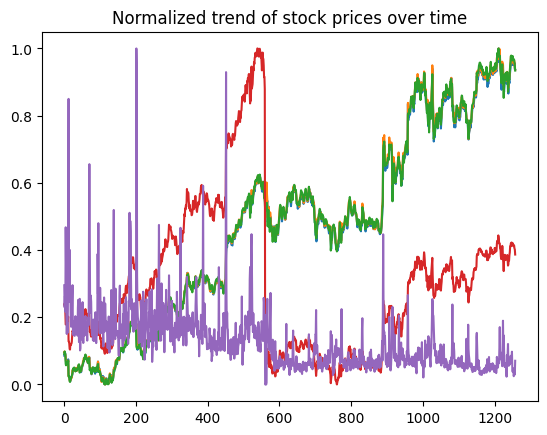

In [21]:
plt.plot(train_scaled)
plt.title("Normalized trend of stock prices over time")
plt.show()

In [57]:
X_train = []
y_train = []
timesteps = 60

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, :])  # all 5 features
    y_train.append(train_scaled[i, 0])              # still predict Open

X_train, y_train = np.array(X_train), np.array(y_train)

# shape: (samples, timesteps, features=5)
print(X_train.shape)


(1198, 60, 5)


In [58]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
timesteps = 60 # Each prediction uses the previous 50 days to predict the next day

for i in range(timesteps, 1258):
    X_train.append(train_scaled[i-timesteps:i, 0]) # sequences of 50 previous stock prices
    y_train.append(train_scaled[i, 0])             # the stock price immediately after those 50 days

X_train, y_train = np.array(X_train), np.array(y_train)

In [59]:
# Reshaping (for RNN input)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train # is in shape of (samples, timesteps, features) -> (number of training examples, 50, 1 feature=open price)

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        ...,
        [0.07846566],
        [0.08034452],
        [0.08497656]],

       [[0.09701243],
        [0.09433366],
        [0.09156187],
        ...,
        [0.08034452],
        [0.08497656],
        [0.08627874]],

       [[0.09433366],
        [0.09156187],
        [0.07984225],
        ...,
        [0.08497656],
        [0.08627874],
        [0.08471612]],

       ...,

       [[0.92106928],
        [0.92438053],
        [0.93048218],
        ...,
        [0.95475854],
        [0.95204256],
        [0.95163331]],

       [[0.92438053],
        [0.93048218],
        [0.9299055 ],
        ...,
        [0.95204256],
        [0.95163331],
        [0.95725128]],

       [[0.93048218],
        [0.9299055 ],
        [0.93113327],
        ...,
        [0.95163331],
        [0.95725128],
        [0.93796041]]])

In [60]:
y_train

array([0.08627874, 0.08471612, 0.07454052, ..., 0.95725128, 0.93796041,
       0.93688146])

## Create RNN Model

In [61]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


# Initialising the RNN
regressor = Sequential()

# 1st RNN layer with some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# 2nd RNN layer with some Dropout regularisation. Units = neurons. return_sequences needed as another RNN follows
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# 3rd RNN layer with some Dropout regularisation. Deep RNN structure improves pattern learning over time
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# A final 4th RNN layer with some Dropout regularisation. return_sequences is false as outputs only the last timestep
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Output layer - predicts next day's stock price
regressor.add(Dense(units = 1))

# Compiling the RNN
#regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
#regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
regressor.compile(optimizer='adam', loss='mean_squared_error')
# added a validation split (10%) and EarlyStopping to prevent overfitting and automatically restore the best model weights.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = regressor.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.5869 - val_loss: 0.0365
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.2736 - val_loss: 0.0039
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.2028 - val_loss: 0.0051
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1708 - val_loss: 0.0366
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1243 - val_loss: 0.0050
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1035 - val_loss: 0.0013
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0785 - val_loss: 5.0855e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0742 - val_loss: 4.6111e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0575 - val_loss: 0.0011
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0514 - val_loss: 0.0087
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0446 - val_loss: 0.0048
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 5

## Predictions and Visualising RNN Model

In [62]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv(path+'/Google_Stock_Price_Test.csv')
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [63]:
# Ground truth for comparison
real_stock_price = dataset_test[['Open', 'High', 'Low', 'Close', 'Volume']].values
real_stock_price

array([[778.81, 789.63, 775.8, 786.14, '1,657,300'],
       [788.36, 791.34, 783.16, 786.9, '1,073,000'],
       [786.08, 794.48, 785.02, 794.02, '1,335,200'],
       [795.26, 807.9, 792.2, 806.15, '1,640,200'],
       [806.4, 809.97, 802.83, 806.65, '1,272,400'],
       [807.86, 809.13, 803.51, 804.79, '1,176,800'],
       [805.0, 808.15, 801.37, 807.91, '1,065,900'],
       [807.14, 807.39, 799.17, 806.36, '1,353,100'],
       [807.48, 811.22, 806.69, 807.88, '1,099,200'],
       [807.08, 807.14, 800.37, 804.61, '1,362,100'],
       [805.81, 806.21, 800.99, 806.07, '1,294,400'],
       [805.12, 809.48, 801.8, 802.17, '919,300'],
       [806.91, 806.91, 801.69, 805.02, '1,670,000'],
       [807.25, 820.87, 803.74, 819.31, '1,963,600'],
       [822.3, 825.9, 817.82, 823.87, '1,474,000'],
       [829.62, 835.77, 825.06, 835.67, '1,494,500'],
       [837.81, 838.0, 827.01, 832.15, '2,973,900'],
       [834.71, 841.95, 820.44, 823.31, '2,965,800'],
       [814.66, 815.84, 799.8, 802.32, '

In [64]:
# Getting the predicted stock price of 2017.
"Predictions for day t need the previous 50 days. Some of those days come from training data"

dataset_test['Volume'] = dataset_test['Volume'].str.replace(',', '').astype(float)

# Combine the features from both training and test sets
dataset_total = pd.concat((dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']], dataset_test[['Open', 'High', 'Low', 'Close', 'Volume']]), axis = 0)

# Get the inputs for prediction, including the required timesteps from the end of the training set
# and all features
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values

# Scale the inputs
inputs = scaler.transform(inputs)
inputs

array([[0.9299055 , 0.93239584, 0.9439309 , 0.39367171, 0.04256308],
       [0.93113327, 0.93086447, 0.93485755, 0.39121867, 0.03705647],
       [0.92750577, 0.94901675, 0.94455599, 0.40618497, 0.04673608],
       [0.94415507, 0.95443255, 0.9534778 , 0.40222979, 0.05464958],
       [0.93876032, 0.94668235, 0.95628125, 0.40646059, 0.03722467],
       [0.93403527, 0.9337778 , 0.93911956, 0.3955046 , 0.05436123],
       [0.93483518, 0.93887613, 0.94480224, 0.39597315, 0.03382459],
       [0.9313937 , 0.94242441, 0.94764358, 0.39794386, 0.04345615],
       [0.94636878, 0.9718565 , 0.96292999, 0.41902898, 0.08205847],
       [0.96569685, 0.97744038, 0.98653205, 0.42762841, 0.07044053],
       [0.97510976, 0.97626384, 0.9827436 , 0.42138555, 0.07006808],
       [0.95966962, 0.96791604, 0.97889832, 0.42469303, 0.05039247],
       [0.97808617, 0.99719872, 0.99939385, 0.4436283 , 0.0676652 ],
       [1.        , 1.        , 1.        , 0.43613136, 0.06281538],
       [0.98076494, 0.98188507, 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


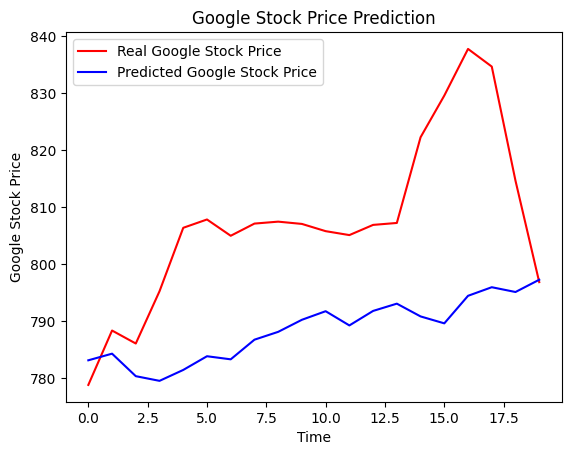

In [65]:
# Creates sliding windows just like training data.
X_test = []
# The loop should go from 'timesteps' to the end of the 'inputs' array
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, 0])

# Reshaped for RNN input.
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)

# Predictions are scaled back to original price values

# To inverse transform, we need to provide a 2D array with the same number of features (5)

num_features = scaler.n_features_in_
dummy_array = np.zeros((len(predicted_stock_price), num_features))
dummy_array[:, 0] = predicted_stock_price[:, 0] # Place 'Open' price predictions in the first column

inverse_transformed_predictions = scaler.inverse_transform(dummy_array)
predicted_open_price = inverse_transformed_predictions[:, 0] # Extract the inverse transformed 'Open' price


# Visualising the results -> how well the model follows the real trend?
# Plot the 'Open' price from the real_stock_price for comparison
plt.plot(real_stock_price[:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_open_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## Assignment
Try to improve the result! Document your actions and conclusions further in this notebook.

Adding more features instead of only Open may improve the model:
Added High, Low, Close, and Volume in addition to Open.
Model learned volatility, momentum, and volume‑driven behavior.

Added Validation Split + Early Stopping:

Introduced a 10% validation set.

EarlyStopping prevents overfitting and restores the best weights.
More stable training and lower validation loss.

Experimented with Longer Timesteps:
Tested 50, 60, 90 windows.
Longer windows improved trend prediction and reduced noise.

Conclusions:

Using multiple features (Open, High, Low, Close, Volume)
improved the model ability to capture market dynamics.

Early stopping prevented overfitting and stabilized training.

Longer timesteps helped the model understand broader trends.

Overall, the improved model produced predictions that more closely followed the real stock price curve, both in trend and magnitude.

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook